In [32]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Resized,
    ScaleIntensityd,
    RandRotate90d,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [33]:
root_dir ='/home/xindong/project/unet-segment3d-circle/'
print(root_dir)
data_dir = os.path.join(root_dir, "data_circle")
print(data_dir)

/home/xindong/project/unet-segment3d-circle/
/home/xindong/project/unet-segment3d-circle/data_circle


In [34]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
print(len(data_dicts))
train_files, val_files = data_dicts[:20], data_dicts[-9:]

print(train_files)
print(len(train_files))
print(len(val_files))
print(val_files)

29
[{'image': '/home/xindong/project/unet-segment3d-circle/data_circle/imagesTr/img001.nii.gz', 'label': '/home/xindong/project/unet-segment3d-circle/data_circle/labelsTr/label001.nii.gz'}, {'image': '/home/xindong/project/unet-segment3d-circle/data_circle/imagesTr/img002.nii.gz', 'label': '/home/xindong/project/unet-segment3d-circle/data_circle/labelsTr/label002.nii.gz'}, {'image': '/home/xindong/project/unet-segment3d-circle/data_circle/imagesTr/img003.nii.gz', 'label': '/home/xindong/project/unet-segment3d-circle/data_circle/labelsTr/label003.nii.gz'}, {'image': '/home/xindong/project/unet-segment3d-circle/data_circle/imagesTr/img004.nii.gz', 'label': '/home/xindong/project/unet-segment3d-circle/data_circle/labelsTr/label004.nii.gz'}, {'image': '/home/xindong/project/unet-segment3d-circle/data_circle/imagesTr/img005.nii.gz', 'label': '/home/xindong/project/unet-segment3d-circle/data_circle/labelsTr/label005.nii.gz'}, {'image': '/home/xindong/project/unet-segment3d-circle/data_circle

In [35]:
set_determinism(seed=0)

In [36]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Resized(keys=['image', 'label'], spatial_size=(128,128,64)),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        # ScaleIntensityRanged(
        #    keys=["image"], a_min=13000, a_max=35000,
        #    b_min=0.0, b_max=1.0, clip=True,
        # ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96,64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        ScaleIntensityd(["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Resized(keys=['image', 'label'], spatial_size=(128,128,64)),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=13000, a_max=35000,
        #     b_min=0.0, b_max=1.0, clip=True,
        # ),
       
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)


 # define transforms for image and segmentation
# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Resized(keys=['image', 'label'], spatial_size=(1024,1024)),
#         ScaleIntensityd(keys="image"),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"], label_key="label", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
#         ),
#         RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 1]),
#         EnsureTyped(keys=["image", "label"]),
#     ]
# )

# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         ScaleIntensityd(keys="image"),
#         EnsureTyped(keys=["image", "label"]),
#     ]
# )



image shape: torch.Size([128, 128, 64]), label shape: torch.Size([128, 128, 64])


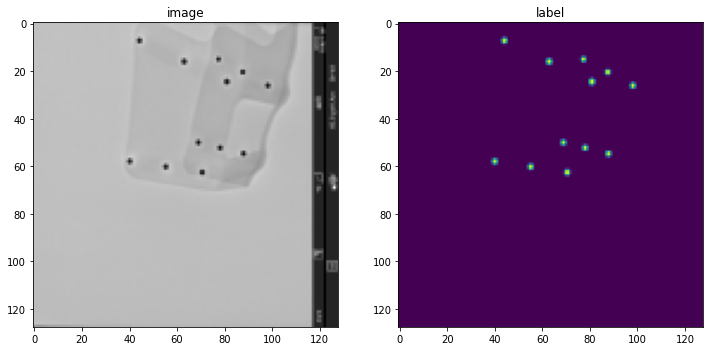

In [37]:

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:,63], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:,:,63])
plt.show()

In [38]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:00<00:00, 16.89it/s]


In [39]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [40]:
max_epochs = 1000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 128, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/1000
1/10, train_loss: 0.6956
2/10, train_loss: 0.6918
3/10, train_loss: 0.6901
4/10, train_loss: 0.6873
5/10, train_loss: 0.6882
6/10, train_loss: 0.6841
7/10, train_loss: 0.6815
8/10, train_loss: 0.6800
9/10, train_loss: 0.6794
10/10, train_loss: 0.6754
epoch 1 average loss: 0.6853
----------
epoch 2/1000
1/10, train_loss: 0.6788
2/10, train_loss: 0.6747
3/10, train_loss: 0.6734
4/10, train_loss: 0.6713
5/10, train_loss: 0.6694
6/10, train_loss: 0.6711
7/10, train_loss: 0.6690
8/10, train_loss: 0.6709
9/10, train_loss: 0.6677
10/10, train_loss: 0.6655
epoch 2 average loss: 0.6712
saved new best metric model
current epoch: 2 current mean dice: 0.0018
best mean dice: 0.0018 at epoch: 2
----------
epoch 3/1000
1/10, train_loss: 0.6632
2/10, train_loss: 0.6654
3/10, train_loss: 0.6634
4/10, train_loss: 0.6620
5/10, train_loss: 0.6655
6/10, train_loss: 0.6609
7/10, train_loss: 0.6630
8/10, train_loss: 0.6597
9/10, train_loss: 0.6592
10/10, train_loss: 0.6567
epoch 3 ave

In [41]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7103 at epoch: 800


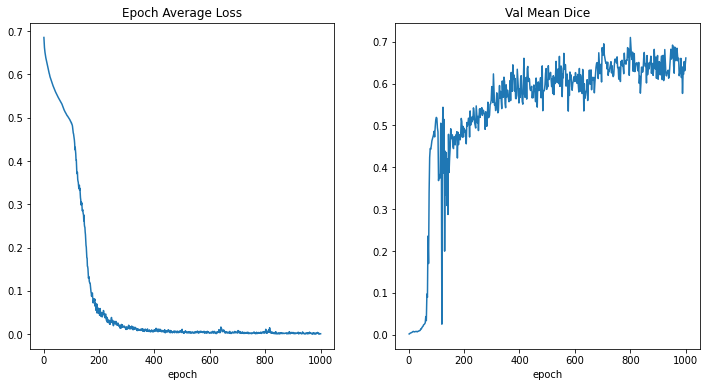

In [42]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 2, 128, 128, 64])


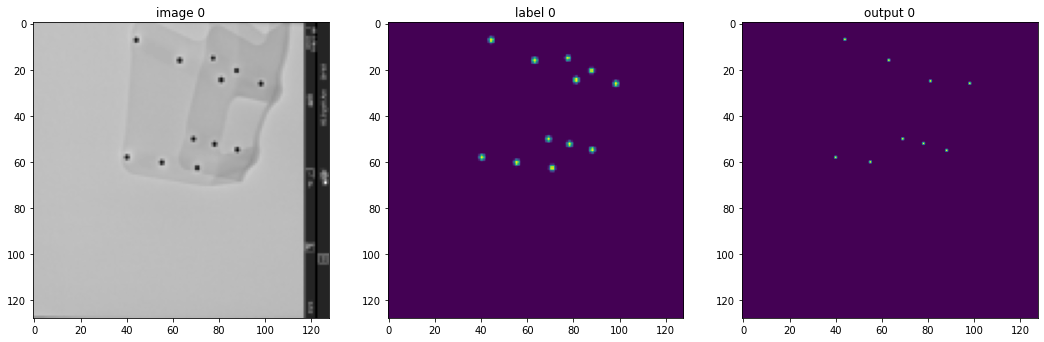

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 2, 128, 128, 64])


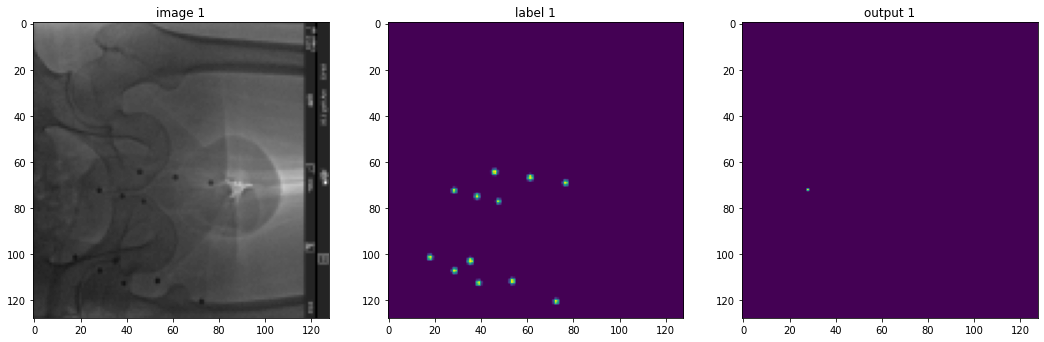

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 2, 128, 128, 64])


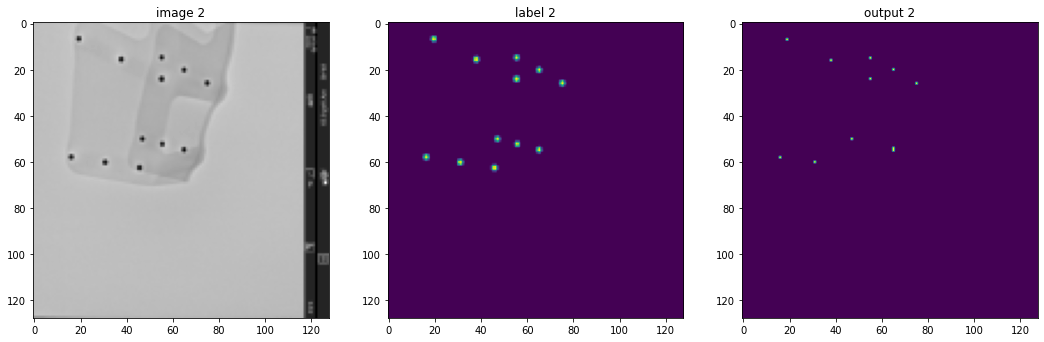

In [43]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        print(val_data["image"].size())
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 1], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 1])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        print(val_outputs.size())
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :,1])
        plt.show()
        if i == 2:
            break